#### Name: Barış Bilen <br> 

<h1><center>Homework 3</center></h1>

<h3>Submission Instructions</h3>
<p>
For submission, you only need to submit your Jupyter Notebook file named "StudentName_ID.ipynb"

</p>

<h3> Homework Instructions </h3>

<p>In this homework, you will implement Girvan-Newman algorithm, and use the algorithm to decompose the network into a number of modules so that it has the highest modularity. Remember the steps of Girvan-Newman algorithm from Graph Theory Blink 9.3:

<ol>
  <li>Calculate the betweenness centrality of each edge in graph G</li>
  <li>Remove the edge with the highest betweenness centrality. Choose randomly in case same score occurs.</li>
  <li>Recalculate the betweenness centrality of all remaining edges</li>
  <li>Repeat steps 2 and 3 until no edges remain. </li>
</ol>

You will need to modify the above steps so that you find the number of connected components that has the highest modularity. To do that, you can calculate modularity each time new connected component is formed during the Girvan-Newman algorithm, and find the decomposition with highest modularity. Don't forget to compute the modularity of the initial network, as network might not consist any modules 

<h2>WHAT YOU NEED TO DO</h2>
<ol>
    <li> Read and visualize the given graph adjacency matrix files. Give brief comments about the networks' hiearchy and modularity <b>(20p)</b>
    <li> Implement the Girvan-Newman algorithm: Write a function that uses Girvan-Newman algorithm to find the number of connected components that gives the highest modularity. In the same function or another function, return the new graph with the number of connected components you have found (basically, remove edges until the number of connected components are equal to the one you found with your algorithm). <b>(60p)</b>
    <li>Apply the function on the given networks. Visualize the final results. Assign different colors to each node in the visualization. <b>(10p)</b>
    <li> What conclusions can you derive about the networks after you run the algorithm on them and visualize the final result? Give brief comments. <b>(10p)</b>
    <li><b>BONUS</b> What are the key differences between Agglomerative Clustering and Divisive Clustering? Which one of these does the Girvan-Newman algorithm belong to? Explain.<b>(3p)</b> 

Below, I have given you some basic functions to start with. 
</p>

In [1]:
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt

You can use RandomGraph function to create a random graph that returns the graph as both networkx.Graph and adjacency matrix as numpy.array.

(Optional, will not affect your grade) You can modify the VisualiseGraph function to give each connected component different graph, or make other interesting visualizations. Play with it however you want!

In [2]:
def RandomAdjacencyMatrix(n = 10, p = 0.5):
    M = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i+1, n):
            if np.random.rand() < p:
                M[i,j], M[j, i] = 1, 1
    return M

def RandomGraph(n = 10, p = 0.5):
    '''
    Creates a random networkx undirected, unweighted graph
    
    Inputs:
        n: number of nodes in graph
        p: probability of an edge being included
        
    Outputs:
        M: Adjacency matrix as numpy array
        G: nx Graph
        
    '''
    M = RandomAdjacencyMatrix(n, p)
    edges = np.transpose(np.where(M==1))
    
    G = nx.Graph()
    for i in range(edges.shape[0]):
        G.add_edge(edges[i, 0], edges[i, 1])
    
    return G, M

def VisualizeGraph(G):
    nx.draw_networkx(G)
    plt.show()
    

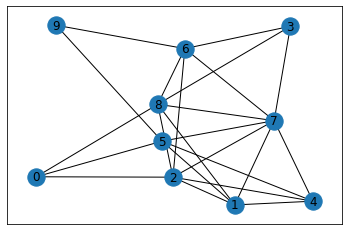

In [3]:
n = 10
p = 0.5
G, M = RandomGraph(n, p)
VisualizeGraph(G)

## You can start from here.

Implement all your codes and write all your comments below this cell. 

For the algorithm; you are only allowed to use networkx to compute <b>modularity, connected components and betwenness centralities.</b> You need to implement Girvan-Nerman and rest of the algorithm by yourself. 

### 1.Reading and Visualizing Given Data

In [4]:
adjMat_N1 = np.load("NetworkData1.npy")
G1 = nx.from_numpy_array(adjMat_N1)

adjMat_N2 = np.load("NetworkData2.npy")
G2 = nx.from_numpy_array(adjMat_N2)

adjMat_N3 = np.load("NetworkData3.npy")
G3 = nx.from_numpy_array(adjMat_N3)

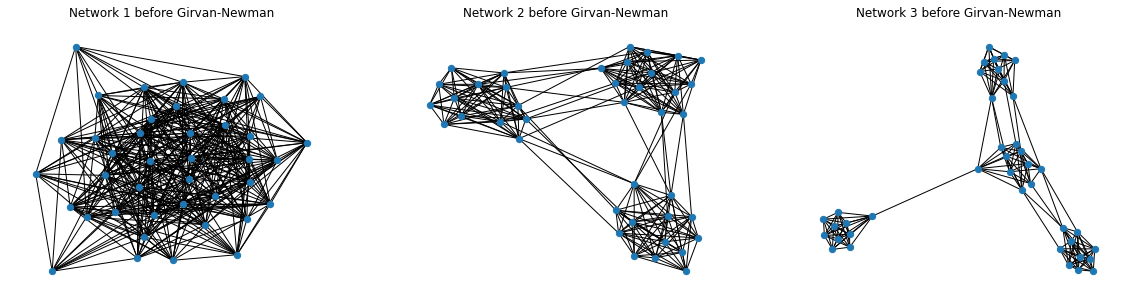

In [5]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))

axs[0].title.set_text("Network 1 before Girvan-Newman")
axs[1].title.set_text("Network 2 before Girvan-Newman")
axs[2].title.set_text("Network 3 before Girvan-Newman")

pos00 = nx.spring_layout(G1)
pos01 = nx.spring_layout(G2)
pos02 = nx.spring_layout(G3)

nx.draw(G1, ax=axs[0], pos=pos00, node_size = 40)
nx.draw(G2, ax=axs[1], pos=pos01, node_size = 40)
nx.draw(G3, ax=axs[2], pos=pos02, node_size = 40)

plt.show()

If we look to network 1 it has no noticeable moduls also a very dense graph. Network 2-3 has some noticeable densely connected subgraphs. So we can say that network 1 is a non-modular graph and network 2-3 are modular graphs.

In [6]:
cc1 = list(nx.connected_components(G1))
cc2 = list(nx.connected_components(G2))
cc3 = list(nx.connected_components(G3))

print("###"+ "-"*10 + "Modularities before Girvan-Newman" + "-"*10 + "###")
print("Network 1:", nx_comm.modularity(G1,cc1))
print("Network 2:", nx_comm.modularity(G2,cc2))
print("Network 3:", nx_comm.modularity(G3,cc3))

###----------Modularities before Girvan-Newman----------###
Network 1: 0.0
Network 2: 1.1102230246251565e-16
Network 3: 0.0


When we look to the graph of network 1 we can see that there is a lot of between module connections so modularity value 0 is very normal. Even though we can see that network 2 and 3 has modules there are still a lot of between module connections so this might be the reason that we get 0 or closer to 0 modularity values. 

### 2. Girvan-Newman Algorithm

In [7]:
def girvanNewman(adjMat):
    G = nx.from_numpy_array(adjMat.copy())
    G_modified = G.copy()
    cc = list(nx.connected_components(G))
    
    ###---Initial Assignment---###
    G_Final = G_modified
    adjMat_Final = nx.to_numpy_matrix(G_Final)
    highest_Modularity = nx_comm.modularity(G_Final,cc.copy())
    numberOfCC = nx.number_connected_components(G_Final)
    
    ###---Until there is no edge left---###
    while(G_modified.number_of_edges() != 0):
        bc = nx.edge_betweenness_centrality(G_modified) # Calculating betweenness centrality
        bc = sorted(bc.items(), key = lambda x:x[1], reverse=True) # Choosing the highest betweenness centrality edge
        u,v = bc[0][0]
        G_modified.remove_edge(u,v) # Removing the highest betweenness centrality edge

        cc = list(nx.connected_components(G_modified))
        modularity = nx_comm.modularity(G,cc.copy()) # Calculating modularity
        
        ###---If calculated modularity is higher then the ones calculated before---###
        ###---Update values---###
        if(modularity > highest_Modularity):
            G_Final = G_modified.copy()
            adjMat_Final = nx.to_numpy_matrix(G_Final)
            highest_Modularity = modularity
            numberOfCC = nx.number_connected_components(G_Final)
            
    return G_Final, adjMat_Final, '{:.4f}'.format(highest_Modularity), numberOfCC

### 3. Applying Girvan-Newman to Given Networks

In [8]:
G_GN1, adjMat_GN1, modularity_GN1, numberOfCC_GN1 = girvanNewman(adjMat_N1)
G_GN2, adjMat_GN2, modularity_GN2, numberOfCC_GN2 = girvanNewman(adjMat_N2)
G_GN3, adjMat_GN3, modularity_GN3, numberOfCC_GN3 = girvanNewman(adjMat_N3)

print("###"+ "-"*10 + "Modularities after Girvan-Newman" + "-"*10 + "###")
print("Network 1:", modularity_GN1)
print("Network 2:", modularity_GN2)
print("Network 3:", modularity_GN3)

print("\n###"+ "-"*10 + "Connected Components after Girvan-Newman" + "-"*10 + "###")
print("Network 1:", numberOfCC_GN1)
print("Network 2:", numberOfCC_GN2)
print("Network 3:", numberOfCC_GN3)

###----------Modularities after Girvan-Newman----------###
Network 1: 0.0209
Network 2: 0.5747
Network 3: 0.6822

###----------Connected Components after Girvan-Newman----------###
Network 1: 21
Network 2: 3
Network 3: 4


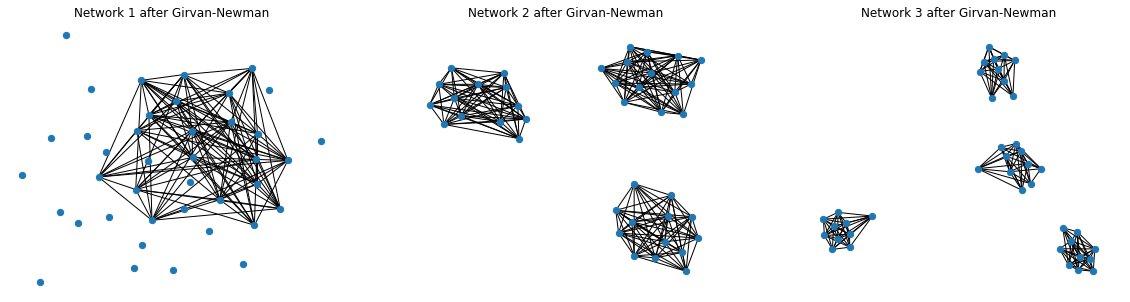

In [9]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))


axs[0].title.set_text("Network 1 after Girvan-Newman")
axs[1].title.set_text("Network 2 after Girvan-Newman")
axs[2].title.set_text("Network 3 after Girvan-Newman")

nx.draw(G_GN1, ax=axs[0], pos=pos00, node_size = 40)
nx.draw(G_GN2, ax=axs[1], pos=pos01, node_size = 40)
nx.draw(G_GN3, ax=axs[2], pos=pos02, node_size = 40)

plt.show()

### 4. Conclusion

After Girvan-Newman we can see that algorithm created 3 and 4 modules in network 2 and 3. By doing so it also disconnected subgraphs of network 2 and 3. For the network 1 because it was a very dense graph we weren't seeing the moduls but after Girvan-Newman now we can clearly see the modul. As seen it has one big modul. After Girvan-Newman it also changed networks modularities. Now we can see this both from graphs and modularity values.

### 5. Key Differences Between Agglomerative Clustering and Divisive Clustering

Agglomerative clustering starts as seeing each data point as a cluster and pairs of clusters are merged while moving upwards in the hierarchy. Divisive clustering starts with one big cluster and splits it while moving down in the hierarchy. 

Agglomerative clustering considers local patterns without thinking global distribution where divisive clustering include global distribution while partitioning.